# Project 2: Forest Cover Type Classification with Dense Neural Networks

This notebook builds and evaluates dense neural networks (DNNs) for multi-class classification on the UCI Forest Covertype dataset.

## Goals
- Build a baseline DNN model.
- Run controlled experiments by changing one major factor at a time.
- Compare training behavior and generalization.
- Select and justify a best-performing model.

In [1]:
# If needed, install dependencies in your environment:
# !pip install numpy pandas matplotlib seaborn scikit-learn tensorflow

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
)

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


In [3]:
# Load data
covtype = fetch_covtype()
X = covtype.data.astype(np.float32)
y_raw = covtype.target.astype(np.int32)  # labels are 1..7

print("X shape:", X.shape)
print("y shape:", y_raw.shape)
print("Classes:", np.unique(y_raw))

X shape: (581012, 54)
y shape: (581012,)
Classes: [1 2 3 4 5 6 7]


In [4]:
# Map labels from 1..7 to 0..6 for one-hot encoding
y = y_raw - 1
num_classes = 7

# First split: 70% train_full, 30% test (stratified)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=SEED,
    stratify=y,
)

# Second split: from train_full, keep 80% train and 20% validation (stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.20,
    random_state=SEED,
    stratify=y_train_full,
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

# Standard scaling: fit on training only, transform val/test using same scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# One-hot encoding
y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_val_oh = to_categorical(y_val, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)

Train shape: (325366, 54)
Validation shape: (81342, 54)
Test shape: (174304, 54)


C:\Users\Christian\AppData\Local\Temp\ipykernel_22660\3901228416.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette="viridis")


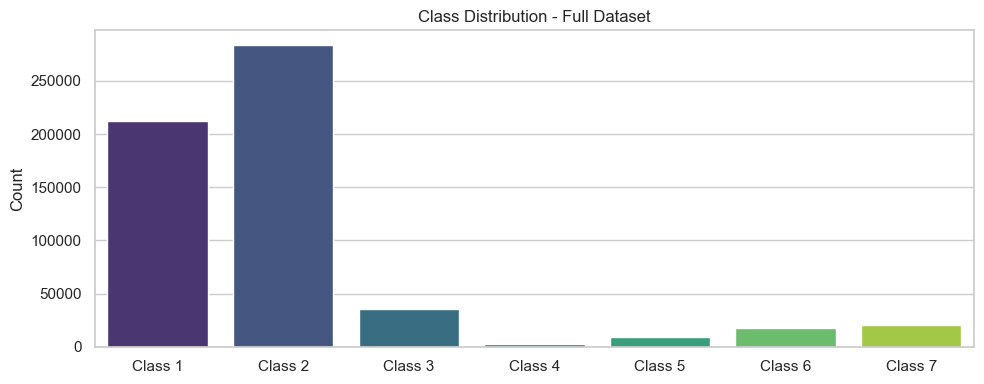

C:\Users\Christian\AppData\Local\Temp\ipykernel_22660\3901228416.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette="viridis")


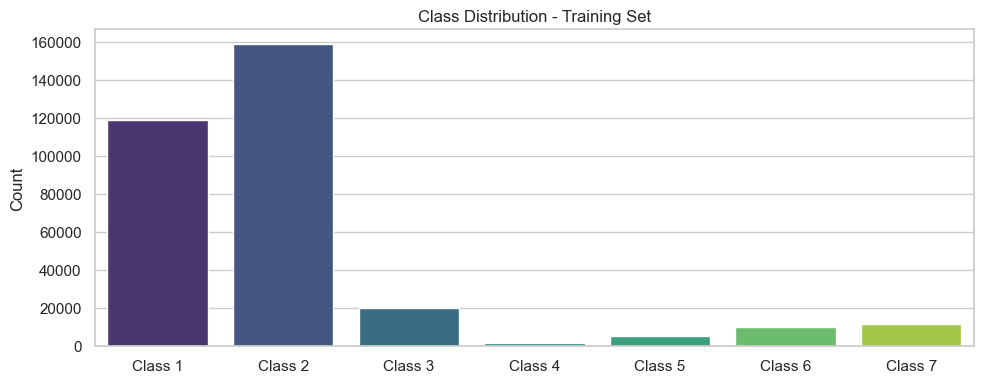

C:\Users\Christian\AppData\Local\Temp\ipykernel_22660\3901228416.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette="viridis")


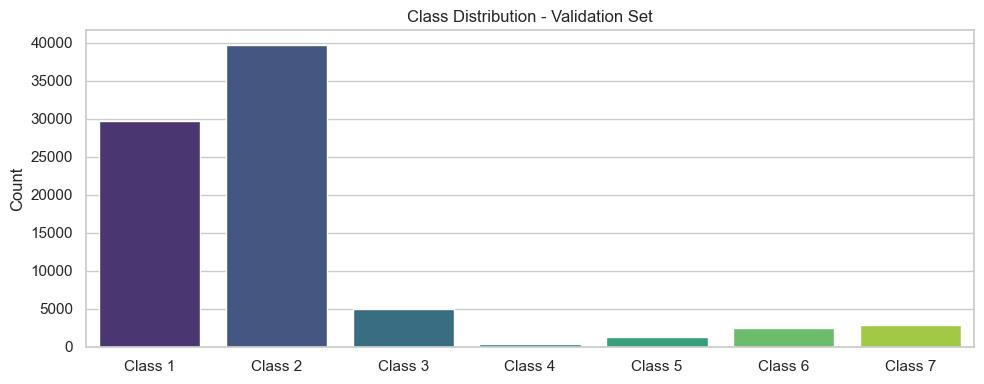

C:\Users\Christian\AppData\Local\Temp\ipykernel_22660\3901228416.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette="viridis")


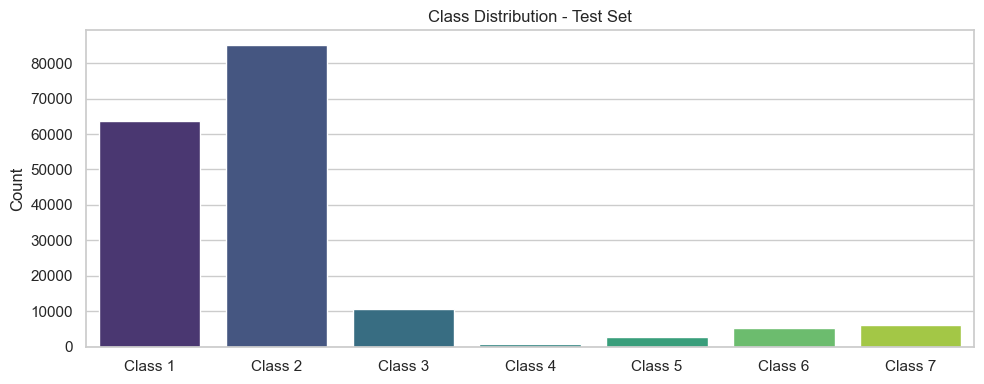

In [5]:
def plot_class_distribution(y_values, title):
    classes, counts = np.unique(y_values, return_counts=True)
    labels = [f"Class {c+1}" for c in classes]

    plt.figure(figsize=(10, 4))
    sns.barplot(x=labels, y=counts, palette="viridis")
    plt.title(title)
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


plot_class_distribution(y, "Class Distribution - Full Dataset")
plot_class_distribution(y_train, "Class Distribution - Training Set")
plot_class_distribution(y_val, "Class Distribution - Validation Set")
plot_class_distribution(y_test, "Class Distribution - Test Set")

In [6]:
def build_dnn(
    input_dim,
    num_classes,
    hidden_layers=(64,),
    activation="relu",
    dropout_rate=0.0,
    l2_lambda=0.0,
    learning_rate=1e-3,
):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    for units in hidden_layers:
        model.add(
            Dense(
                units,
                activation=activation,
                kernel_regularizer=l2(l2_lambda) if l2_lambda > 0 else None,
            )
        )
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def run_experiment(name, config, epochs=20, verbose=1):
    model = build_dnn(
        input_dim=X_train_scaled.shape[1],
        num_classes=num_classes,
        hidden_layers=config["hidden_layers"],
        activation=config["activation"],
        dropout_rate=config["dropout_rate"],
        l2_lambda=config["l2_lambda"],
        learning_rate=config["learning_rate"],
    )

    history = model.fit(
        X_train_scaled,
        y_train_oh,
        validation_data=(X_val_scaled, y_val_oh),
        epochs=epochs,
        batch_size=config["batch_size"],
        verbose=verbose,
    )

    val_probs = model.predict(X_val_scaled, verbose=0)
    val_preds = np.argmax(val_probs, axis=1)
    val_acc = accuracy_score(y_val, val_preds)

    return model, history, val_acc

In [7]:
# Baseline + at least 5 experiments
experiments = {
    "baseline_1x64_relu_lr1e-3_bs64": {
        "hidden_layers": (64,),
        "activation": "relu",
        "dropout_rate": 0.0,
        "l2_lambda": 0.0,
        "learning_rate": 1e-3,
        "batch_size": 64,
    },
    "exp1_deeper_128_64_relu": {
        "hidden_layers": (128, 64),
        "activation": "relu",
        "dropout_rate": 0.0,
        "l2_lambda": 0.0,
        "learning_rate": 1e-3,
        "batch_size": 64,
    },
    "exp2_deeper_256_128_64_relu": {
        "hidden_layers": (256, 128, 64),
        "activation": "relu",
        "dropout_rate": 0.0,
        "l2_lambda": 0.0,
        "learning_rate": 1e-3,
        "batch_size": 64,
    },
    "exp3_activation_elu": {
        "hidden_layers": (128, 64),
        "activation": "elu",
        "dropout_rate": 0.0,
        "l2_lambda": 0.0,
        "learning_rate": 1e-3,
        "batch_size": 64,
    },
    "exp4_dropout_0p3": {
        "hidden_layers": (128, 64),
        "activation": "relu",
        "dropout_rate": 0.3,
        "l2_lambda": 0.0,
        "learning_rate": 1e-3,
        "batch_size": 64,
    },
    "exp5_l2_1e-4": {
        "hidden_layers": (128, 64),
        "activation": "relu",
        "dropout_rate": 0.0,
        "l2_lambda": 1e-4,
        "learning_rate": 1e-3,
        "batch_size": 64,
    },
    "exp6_lr5e-4_bs128": {
        "hidden_layers": (128, 64),
        "activation": "relu",
        "dropout_rate": 0.0,
        "l2_lambda": 0.0,
        "learning_rate": 5e-4,
        "batch_size": 128,
    },
}

histories = {}
trained_models = {}
results = []

for name, cfg in experiments.items():
    print(f"\nTraining: {name}")
    model, history, val_acc = run_experiment(name, cfg, epochs=20, verbose=1)

    histories[name] = history.history
    trained_models[name] = model

    results.append(
        {
            "experiment": name,
            "val_accuracy_last": history.history["val_accuracy"][-1],
            "val_accuracy_best": float(np.max(history.history["val_accuracy"])),
            "train_accuracy_last": history.history["accuracy"][-1],
            "val_loss_last": history.history["val_loss"][-1],
        }
    )

results_df = pd.DataFrame(results).sort_values("val_accuracy_best", ascending=False)
results_df


Training: baseline_1x64_relu_lr1e-3_bs64
Epoch 1/20
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7386 - loss: 0.6196 - val_accuracy: 0.7565 - val_loss: 0.5661
Epoch 2/20
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7682 - loss: 0.5397 - val_accuracy: 0.7661 - val_loss: 0.5343
Epoch 3/20
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7779 - loss: 0.5161 - val_accuracy: 0.7732 - val_loss: 0.5166
Epoch 4/20
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7844 - loss: 0.5003 - val_accuracy: 0.7800 - val_loss: 0.5029
Epoch 5/20
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7904 - loss: 0.4882 - val_accuracy: 0.7864 - val_loss: 0.4924
Epoch 6/20
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7950 - loss: 0.4788 - val_accuracy: 0.7912 - val_loss: 0.4841
Epoch 7/20
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7995 - loss: 0.4712 - val_accuracy: 0.7951 - val_loss: 0.4758
Epoch 8/20
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms

,experiment,val_accuracy_last,val_accuracy_best,train_accuracy_last,val_loss_last
2,exp2_deeper_256_128_64_relu,0.917644,0.917644,0.929418,0.212181
1,exp1_deeper_128_64_relu,0.889073,0.889073,0.892352,0.274305
5,exp5_l2_1e-4,0.880185,0.880185,0.883390,0.344785
3,exp3_activation_elu,0.877431,0.877431,0.879536,0.296964
6,exp6_lr5e-4_bs128,0.865543,0.865543,0.871744,0.328553
4,exp4_dropout_0p3,0.838140,0.838251,0.805072,0.384273
0,baseline_1x64_relu_lr1e-3_bs64,0.820413,0.820413,0.823254,0.427687


Best experiment based on validation accuracy: exp2_deeper_256_128_64_relu


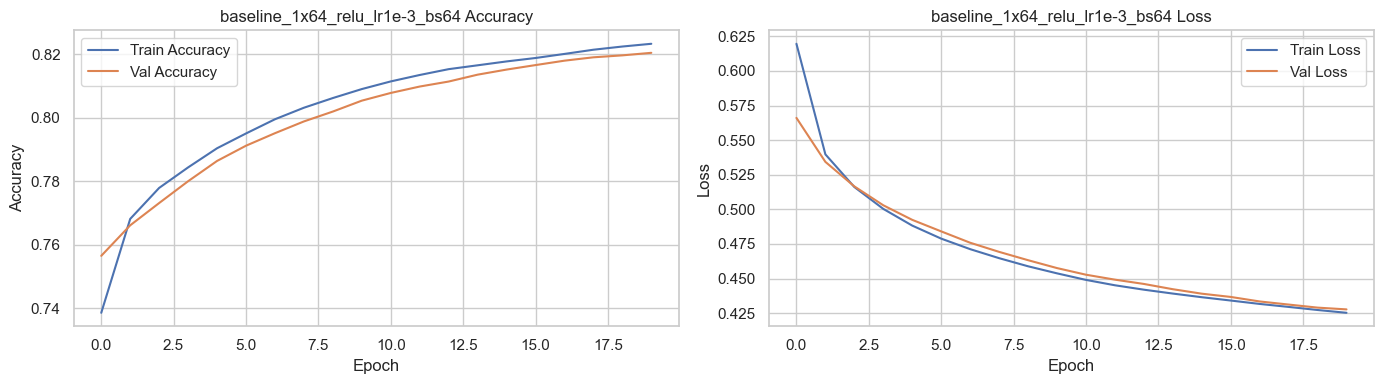

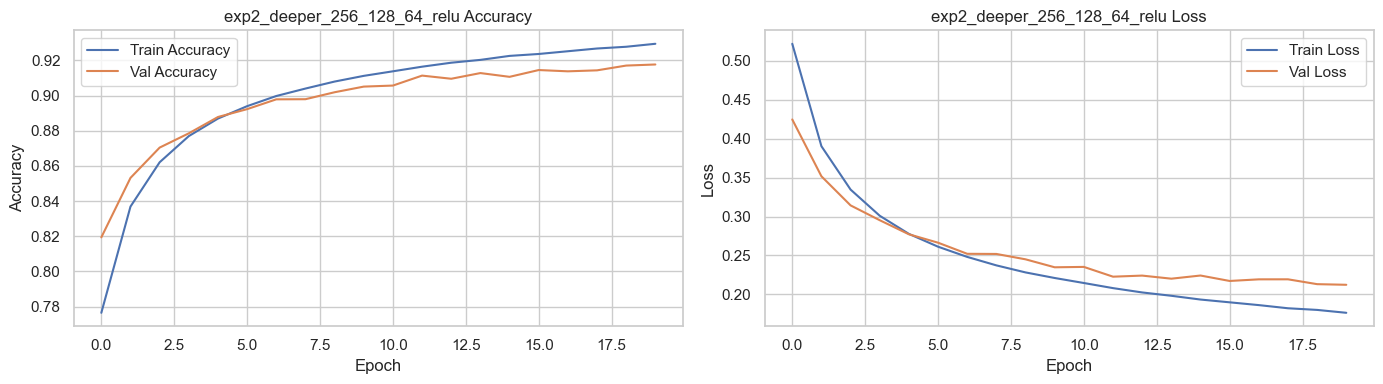

In [8]:
def plot_history(history, title_prefix=""):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    axes[0].plot(history["accuracy"], label="Train Accuracy")
    axes[0].plot(history["val_accuracy"], label="Val Accuracy")
    axes[0].set_title(f"{title_prefix} Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()

    axes[1].plot(history["loss"], label="Train Loss")
    axes[1].plot(history["val_loss"], label="Val Loss")
    axes[1].set_title(f"{title_prefix} Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


# Plot baseline and best experiment curves for visual comparison
baseline_name = "baseline_1x64_relu_lr1e-3_bs64"
best_name = results_df.iloc[0]["experiment"]

print("Best experiment based on validation accuracy:", best_name)
plot_history(histories[baseline_name], title_prefix=f"{baseline_name}")
if best_name != baseline_name:
    plot_history(histories[best_name], title_prefix=f"{best_name}")

Test Accuracy (exp2_deeper_256_128_64_relu): 0.9160


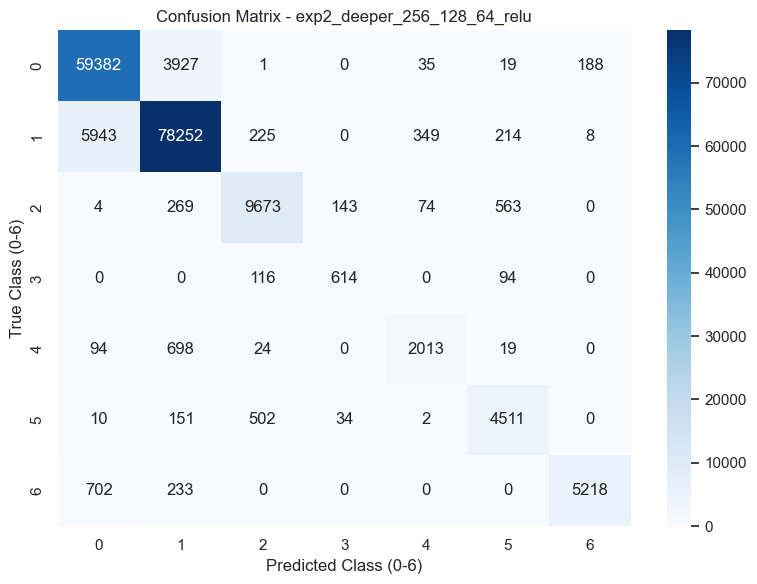

Classification Report:
              precision    recall  f1-score   support

           0     0.8979    0.9344    0.9158     63552
           1     0.9368    0.9207    0.9287     84991
           2     0.9177    0.9018    0.9097     10726
           3     0.7762    0.7451    0.7604       824
           4     0.8140    0.7068    0.7566      2848
           5     0.8323    0.8658    0.8487      5210
           6     0.9638    0.8480    0.9022      6153

    accuracy                         0.9160    174304
   macro avg     0.8770    0.8461    0.8603    174304
weighted avg     0.9165    0.9160    0.9159    174304



In [9]:
# Evaluate best model on test set
best_model = trained_models[best_name]

test_probs = best_model.predict(X_test_scaled, verbose=0)
test_preds = np.argmax(test_probs, axis=1)

test_acc = accuracy_score(y_test, test_preds)
print(f"Test Accuracy ({best_name}): {test_acc:.4f}")

cm = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_name}")
plt.xlabel("Predicted Class (0-6)")
plt.ylabel("True Class (0-6)")
plt.tight_layout()
plt.show()

print("Classification Report:")
print(classification_report(y_test, test_preds, digits=4))

## Report Notes (Fill This After Running)

Use this section as a draft for your written report:

1. **Baseline result**: record train/validation/test accuracy and key observations.
2. **Experiment comparison**: discuss each single change and how it affected learning curves and validation metrics.
3. **Best model**: explain why it was selected (validation trend + test performance + stability).
4. **Reflection**: what worked well, what did not, and what you would try next (e.g., additional regularization, callbacks, or feature engineering).

In [10]:
# Optional: save experiment table for report appendix
results_df.to_csv("dnn_experiment_results.csv", index=False)
results_df.head(10)

,experiment,val_accuracy_last,val_accuracy_best,train_accuracy_last,val_loss_last
2,exp2_deeper_256_128_64_relu,0.917644,0.917644,0.929418,0.212181
1,exp1_deeper_128_64_relu,0.889073,0.889073,0.892352,0.274305
5,exp5_l2_1e-4,0.880185,0.880185,0.883390,0.344785
3,exp3_activation_elu,0.877431,0.877431,0.879536,0.296964
6,exp6_lr5e-4_bs128,0.865543,0.865543,0.871744,0.328553
4,exp4_dropout_0p3,0.838140,0.838251,0.805072,0.384273
0,baseline_1x64_relu_lr1e-3_bs64,0.820413,0.820413,0.823254,0.427687
